In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecasting.dataset import import_data, preprocess_data, make_train_test_split, split_into_x_y
from forecasting.features import reformat_columns, make_features, make_col_transformer
from forecasting.utils import train_config

## Importing data

In [2]:
df_raw = import_data(train_config['input_data_path'])
df = reformat_columns(df_raw)
df = make_features(df)
df_processed = preprocess_data(df)
X, y = split_into_x_y(df_processed)

X_train, X_test, y_train, y_test = make_train_test_split(X, y)

## Exploratory data analysis

The data contains traffic volume for specific time (at hourly intervals between years 2012 - 2018). I perform data analysis to explore:

 - seasonality of the data (daily, annualy)
 - importnace of additional factors like weather

In [3]:
from forecasting.plots import plot_traffic_histogram, plot_aggregated_traffic, plot_boxplot

 - the histogram reveals non-normal distribution of the traffic data, with 3 distinct peaks
 - there is particularly high frequency of small traffic volume, ranging between from approx. 250 to 450

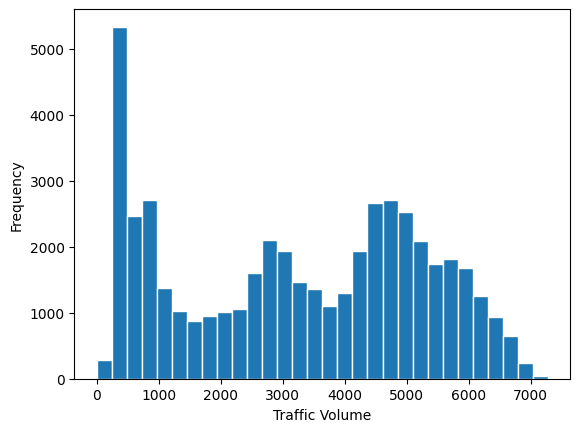

In [4]:
plot_traffic_histogram(df)

The data shows very strong seasonal patters:
 - daily seasonality is particularly strong, with distinct peaks during morning and afternoon rush hours, followed by a significant drop during night time
 - monthly seasonality is less pronounced, but the winter months (January, November, and December) generally show reduced activity
 - weekly patterns also influence the traffic, with lower volumes observed during the weekends, especially on Sundays

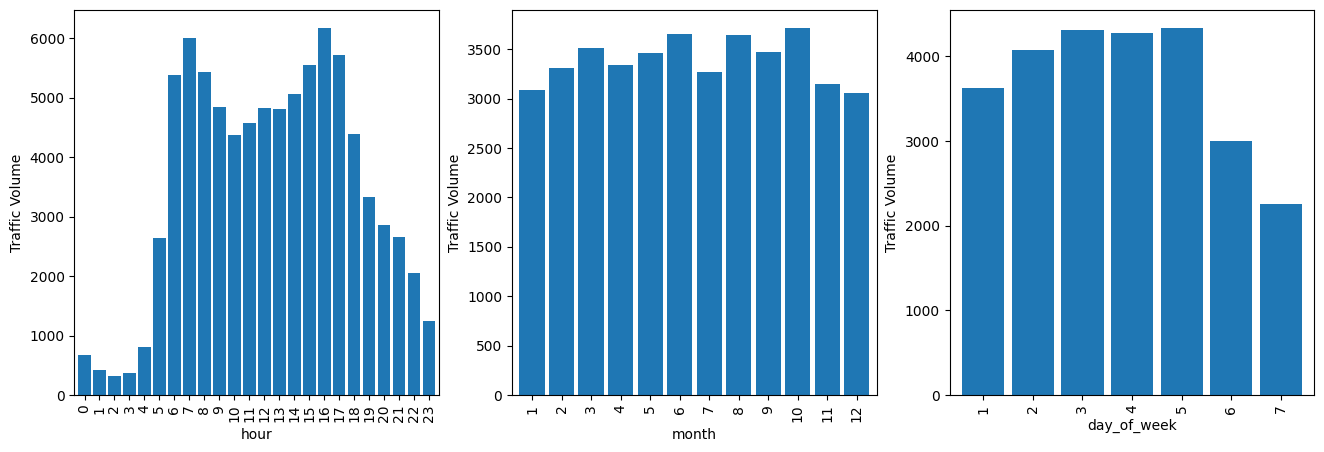

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_aggregated_traffic(df, 'hour', ax=axes[0])
plot_aggregated_traffic(df, 'month', ax=axes[1])
plot_aggregated_traffic(df, 'day_of_week', ax=axes[2])

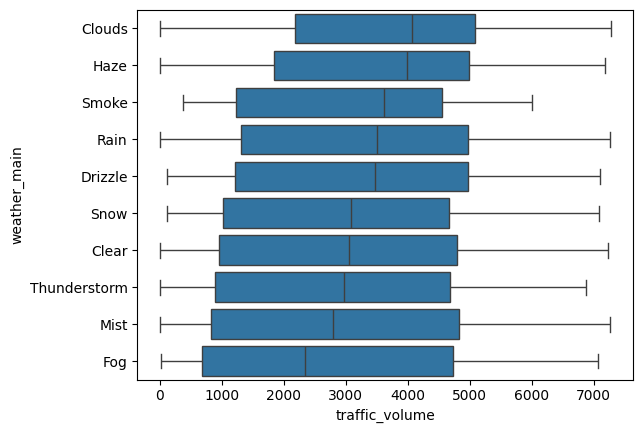

In [6]:
plot_boxplot(df, 'weather_main', top=10)

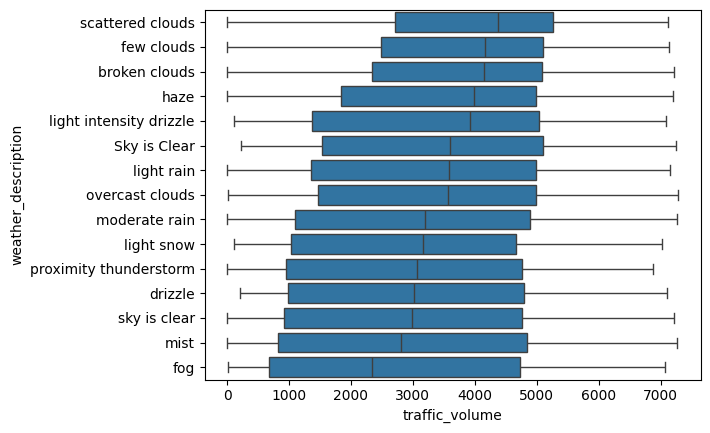

In [7]:
plot_boxplot(df, 'weather_description', top=15)

## Modelling

In [8]:
from forecasting.modelling.model_selection import make_random_search, baseline_models_estimation

#### Baseline models
Estimating baseline models with default parameters. <br> Based on the result I get the idea of which algorithm is promising 
and worth further exploration in hyperparameters tuning

In [9]:
baseline_results = baseline_models_estimation(X_train, y_train)

Running pipeline for LinearRegression
Running pipeline for Ridge
Running pipeline for ElasticNet
Running pipeline for RandomForestRegressor


#### Performance of baseline models
Random forest regressor clearly outperforms other algorithms - the mean squared error is significantly lower <br>
In the next step, its performance can be further improved by utilizing hyperparameters tuning technique

<BarContainer object of 4 artists>

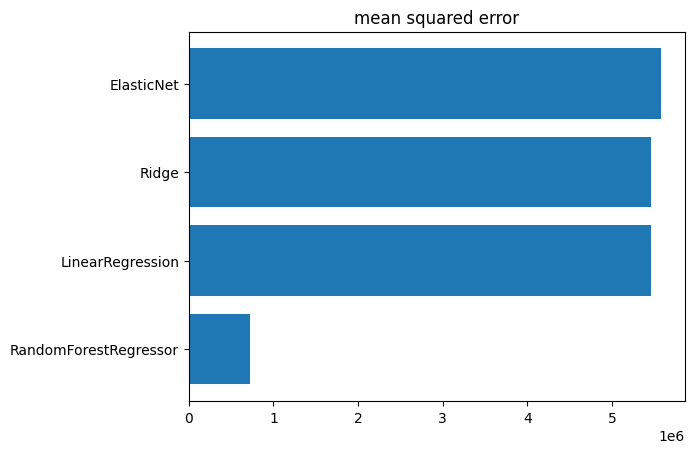

In [10]:
plt.title('mean squared error')
plt.barh(baseline_results.keys(), -np.array(list(baseline_results.values())))

#### Hyperparameters optimization using random search
I select two best performing baseline models and use them in random search to tune hyperparameters. <br>
Finally, the best model from the random search will be used

In [11]:
top_2_models = list(baseline_results.keys())[:2]
results_rs = make_random_search(top_2_models, X_train, y_train)

Running random search for RandomForestRegressor
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Running random search for LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\krzysztof_rozycki\OneDrive - EPAM\projects\learning\forecasting\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random forest model after hyperparameters optimization significantly outperforms linear regression model, therefore will be used as a final model

Text(0.5, 1.0, 'mean squared error')

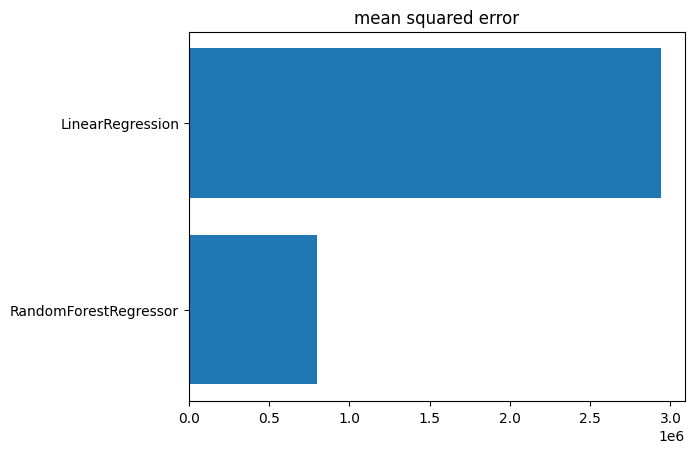

In [12]:
models = results_rs.keys()
results = [-score.best_score_ for score in results_rs.values()]
plt.barh(models, results)
plt.title('mean squared error')

#### Prediction on test data

In [13]:
# make prediction on test data with the model
final_model = results_rs['RandomForestRegressor'].best_estimator_
y_test_pred = final_model.predict(X_test)

The visual analysis show that the model prediction is close to the actual values in out-of-sample data. <br>
The series is mainly driven by the seasonality patterns, which the model was ably to reflect in the forecast

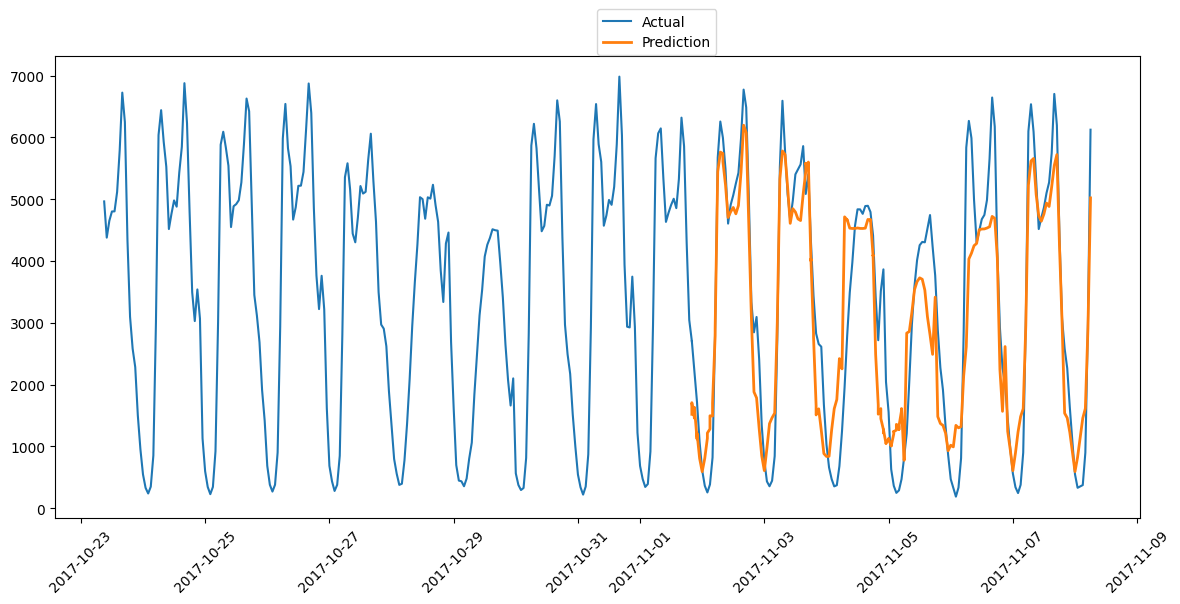

In [14]:
# plot actuals vs predicted values (a sample only for better readability)
n_actuals = 300
n_prediction = 200

y_test_pred_series = pd.Series(y_test_pred, index=X_test.date_time)
y_test_series = pd.Series(y_test, index=X_test.date_time)
y_train_series = pd.Series(y_train, index=X_train.date_time)

plt.figure(figsize=(14, 6))
plt.plot(y_train_series.iloc[-n_actuals:], c='tab:blue', label='Actual')
plt.plot(y_test_series.iloc[:n_prediction], c='tab:blue')
plt.plot(y_test_pred_series.iloc[:n_prediction], c='tab:orange', linestyle='-', linewidth=2, label='Prediction')
plt.legend(loc=[.5, 1.001])
plt.xticks(rotation=45);

In [15]:
from forecasting.utils import save_model
save_model(final_model, '../models/model_jupyter.pkl')

PicklingError: Can't pickle <function cos_cycle at 0x000002C015964720>: it's not the same object as forecasting.utils.cos_cycle